In [123]:
# !pip install pycaret -q
!pip install autokeras -q 
!pip install tensorflow -q


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: C:\Users\mathe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: C:\Users\mathe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [38]:

# import pandas as pd
# from sklearn.model_selection import train_test_split

# from pycaret.classification import 

from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import autokeras as ak
import kerastuner
from keras import backend as K


In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
# caminho_cafe_saudavel = '/content/drive/MyDrive/coffe/Saudavel'
caminho_cafe_saudavel = r'C:/Users/mathe/OneDrive/Documentos/Coffee_Data/Saudavel'
# caminho_cafe_nao_saudavel = '/content/drive/MyDrive/coffe/NSaudavel'
caminho_cafe_nao_saudavel = r'C:/Users/mathe/OneDrive/Documentos/Coffee_Data/NSaudavel'

In [41]:
def carregar_imagens(caminho):
    imagens = []
    for arquivo in os.listdir(caminho):
        imagem = cv2.imread(os.path.join(caminho, arquivo))
        imagem = cv2.resize(imagem, (224, 224)) 
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB) 
        imagens.append(imagem)
    return imagens

In [42]:
cafe_saudavel = carregar_imagens(caminho_cafe_saudavel)
cafe_nao_saudavel = carregar_imagens(caminho_cafe_nao_saudavel)

In [43]:
len(cafe_saudavel),len(cafe_nao_saudavel)

(63, 60)

In [44]:
split = 15

X_train_cs = cafe_saudavel[split:]
X_test_cs = cafe_saudavel[:split]

X_train_cns = cafe_nao_saudavel[split:]
X_test_cns = cafe_nao_saudavel[:split]

In [45]:
len(X_train_cs),len(X_test_cs),len(X_train_cns),len(X_test_cns)

(48, 15, 45, 15)

In [46]:
def data_augmentation(imagens):
    aumentadas = []
    for img in imagens:
        contrast = [np.asarray(ImageEnhance.Contrast(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.8, 1.5, 2)))) for _ in range(2)]
        brightness = [np.asarray(ImageEnhance.Brightness(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.8, 1.5, 2)))) for _ in range(2)]
        sharpness = [np.asarray(ImageEnhance.Sharpness(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.8, 1.5, 2)))) for _ in range(2)]
        color = [np.asarray(ImageEnhance.Color(Image.fromarray(img, 'RGB')).enhance(np.random.choice(np.linspace(0.5, 1.5, 5)))) for _ in range(2)]
        flip = [cv2.flip(img, np.random.choice([0, 1, -1])) if np.random.choice([0, 1]) else img for _ in range(2)]
      #   rotate = [Image.fromarray(img, 'RGB').rotate(np.random.choice([0, 90, 180, 250])) for _ in range(5)]
        
      #   aumentadas.extend(img)
        aumentadas.extend(contrast)
        aumentadas.extend(brightness)
        aumentadas.extend(sharpness)
        aumentadas.extend(color)
        aumentadas.extend(flip)
      #   aumentadas.extend(rotate)
    
    return aumentadas

In [47]:
X_train_cs_aug = data_augmentation(X_train_cs)
X_test_cs_aug = data_augmentation(X_test_cs)

X_train_cns_aug = data_augmentation(X_train_cns)
X_test_cns_aug = data_augmentation(X_test_cns)

len(X_train_cs_aug),len(X_test_cs_aug),len(X_train_cns_aug),len(X_test_cns_aug)

(480, 150, 450, 150)

In [48]:
def exibir_exemplos(imagens, titulo):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    fig.suptitle(titulo, fontsize=16)
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(imagens[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

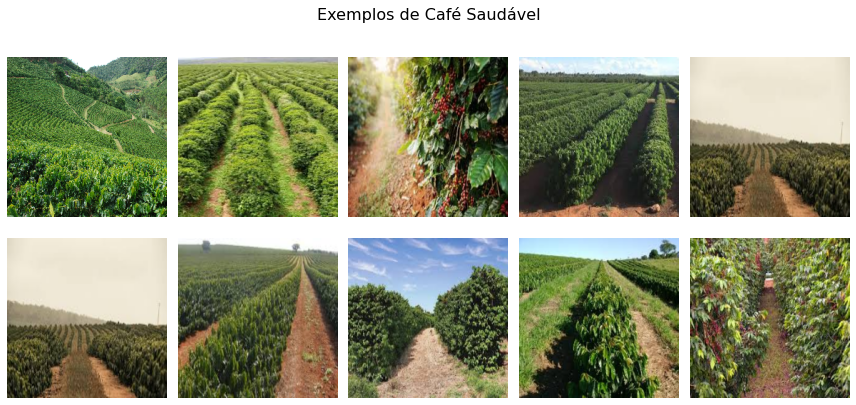

In [49]:
exibir_exemplos(cafe_saudavel, 'Exemplos de Café Saudável')

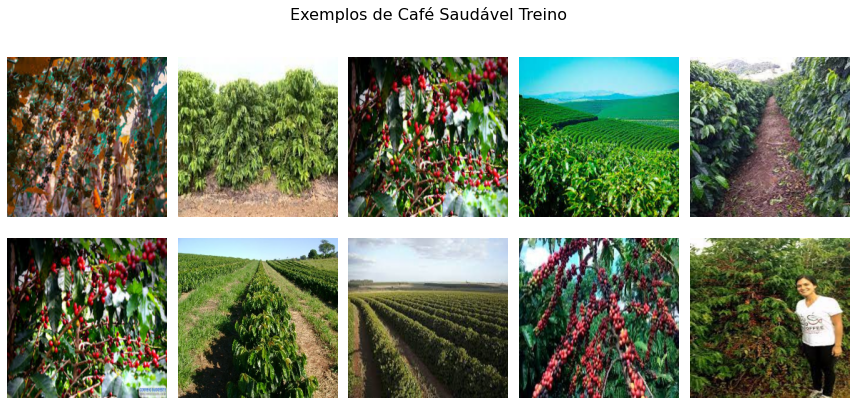

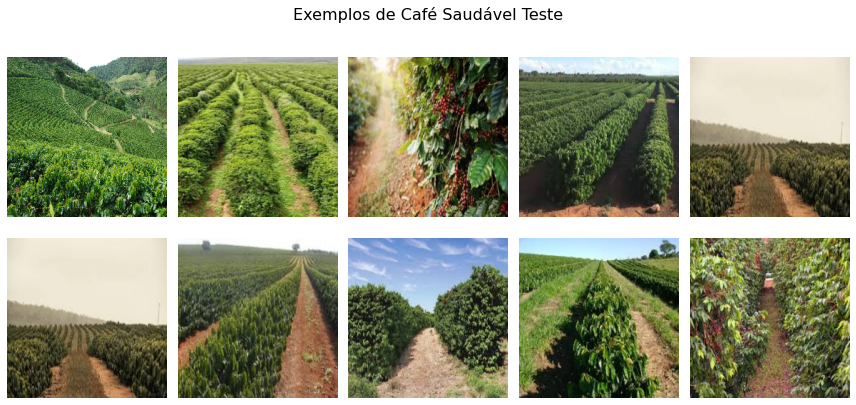

In [50]:
exibir_exemplos(X_train_cs, 'Exemplos de Café Saudável Treino')
exibir_exemplos(X_test_cs, 'Exemplos de Café Saudável Teste')

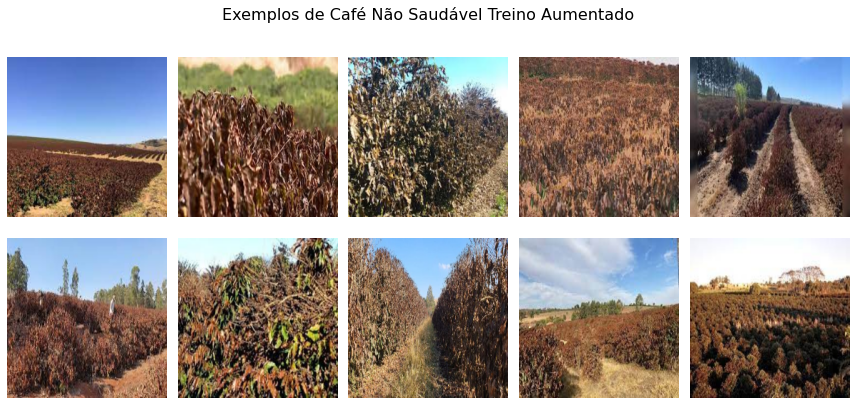

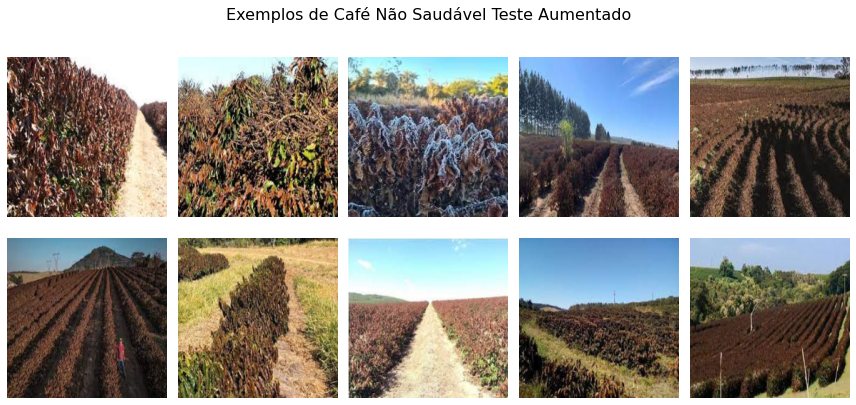

In [51]:
exibir_exemplos(X_train_cns, 'Exemplos de Café Não Saudável Treino Aumentado')
exibir_exemplos(X_test_cns, 'Exemplos de Café Não Saudável Teste Aumentado')

In [52]:
y_train_cs = np.ones(len(X_train_cs_aug))
y_test_cs = np.ones(len(X_test_cs_aug ))

y_train_cns = np.zeros(len(X_train_cns_aug))
y_test_cns = np.zeros(len(X_test_cns_aug ))


len(X_train_cs_aug),len(X_test_cs_aug),len(X_train_cns_aug),len(X_test_cns_aug),len(y_train_cs),len(y_test_cs),len(y_train_cns),len(y_test_cns)

(480, 150, 450, 150, 480, 150, 450, 150)

In [53]:
X_train = np.stack(X_train_cs_aug + X_train_cns_aug)
X_test = np.stack(X_test_cs_aug + X_test_cns_aug)

y_train = np.concatenate((y_train_cs,y_train_cns))
y_test = np.concatenate((y_test_cs,y_test_cns))

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((930, 224, 224, 3), (930,), (300, 224, 224, 3), (300,))

In [54]:
clf = ak.ImageClassifier(overwrite=True, 
                         max_trials=1,
                         distribution_strategy=tf.distribute.MirroredStrategy(),
                         objective='val_accuracy',
                         )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [55]:
clf.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
)

Trial 1 Complete [00h 08m 24s]
val_accuracy: 0.6133333444595337

Best val_accuracy So Far: 0.6133333444595337
Total elapsed time: 00h 08m 24s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
30/30 [==============================] - 50s 2s/step - loss: 84.4420 - accuracy: 0.7548 - val_loss: 25.5679 - val_accuracy: 0.5000
Epoch 2/10
30/30 [==============================] - 49s 2s/step - loss: 8.5999 - accuracy: 0.4624 - val_loss: 0.6503 - val_accuracy: 0.6000
Epoch 3/10
30/30 [==============================] - 49s 2s/step - loss: 0.6712 - accuracy: 0.5796 - val_loss: 0.6511 - val_accuracy: 0.6500
Epoch 4/10
30/30 [==============================] - 49s 2s/step - loss: 0.6526 - accuracy: 0.6054 - val_loss: 0.6161 - val_accuracy: 0.6100
Epoch 5/10
30/30 [==============================] - 49s 2s/step - loss: 0.6290 - accuracy: 0.5774 - val_loss: 0.5429 - val_accuracy: 0.5467
Epoch 6/10
30/30 [==============================] - 49s 2s/step - loss: 0.6927 - accuracy: 0.5581 - val_loss: 2.4146 - val_accuracy: 0.5000
Epoch 7/10
30/30 [==============================] - 49s 2s/step - loss: 0.7786 - accuracy: 0.6172 - val_loss: 0.5179 - val_accuracy: 0.5633
Epoch 8/10
30/30 [

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [56]:
model = clf.export_model()

In [57]:
model.save("model_autokeras")

INFO:tensorflow:Assets written to: model_autokeras\assets


INFO:tensorflow:Assets written to: model_autokeras\assets


In [13]:
from tensorflow import keras
print(keras.__version__)

MODEL_KERAS_PATH = './model_autokeras'
MODEL = keras.models.load_model(MODEL_KERAS_PATH)

2.12.0


ValueError: Unknown layer: 'Custom>CastToFloat32'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.